In [1]:
!pip install janome japanize_matplotlib

     |████████████████████████████████| 19.7MB 1.3MB/s 
     |████████████████████████████████| 4.1MB 42.1MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120276 sha256=24622c01fb9a73e1c8fe44362fb702ab3414449558135b7afb09b9e9899c32b0
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib


In [2]:
from tensorflow.keras.utils import get_file

gz_file_path = get_file('examples_pd.gz', 'ftp://ftp.monash.edu/pub/nihongo/examples_pd.gz',)

8388608/8386099 [==============================] - 2s 0us/step


In [3]:
import gzip
import pandas as pd

with open(gz_file_path, 'rb') as fd:
    gzip_fd = gzip.GzipFile(fileobj=fd)
    raw_lines = gzip_fd.readlines()


In [4]:
import re

NUM_EXAMPLES = 30000

re_line = re.compile(r'(A|B):\s(.+)\t(.+)(?:#ID=\d+\r\n)')

en = []
ja = []

for raw_line in raw_lines[:NUM_EXAMPLES]:
    raw_line = raw_line.decode('euc_jisx0213')
    m = re_line.match(raw_line)
    if m and m[1] == 'A':
        ja.append(m[2])
        en.append(m[3])
print(ja[:5])
print(en[:5])

['＆という記号は、ａｎｄを指す。', '＆のマークはａｎｄの文字を表す。', '（自転車に乗って）フーッ、この坂道はきついよ。でも帰りは楽だよね。', '実のところ物価は毎週上昇している。', '〜と痛切に感じている。']
["The sign '&' stands for 'and'.", 'The mark "&" stands for "and".', '(On a bicycle) Whew! This is a tough hill. But coming back sure will be a breeze.', 'As it is, prices are going up every week.', 'I was acutely aware that..']


In [5]:
import unicodedata

def normalize_en(s):
    return unicodedata.normalize('NFD', s)

def normalize_ja(s):
    return unicodedata.normalize('NFKC', s)

In [6]:
from janome.tokenizer import Tokenizer

t_wakati = Tokenizer(wakati=True)

def tokenize_japanese(text):
    return ' '.join(list(t_wakati.tokenize(text)))

In [7]:
import re

def preprocess_en(w):
    w = normalize_en(w.lower().strip())

    # 単語とそのあとの句読点の間にスペースを挿入
    # 例：　"he is a boy." => "he is a boy ."
    # 参照：- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w

def preprocess_ja(w):
    w = normalize_ja(w)

    w = tokenize_japanese(w)
    w = re.sub(r'[" "]+', " ", w)
    w = w.rstrip().strip()

    # 文の開始と終了のトークンを付加
    # モデルが予測をいつ開始し、いつ終了すれば良いかを知らせるため
    w = '<start> ' + w + ' <end>'
    return w


In [8]:
en_example = "The sign '&' stands for 'and'."
ja_example = '＆という記号は、ａｎｄを指す。'
print(preprocess_en(en_example))
print(preprocess_ja(ja_example))

<start> the sign '&' stands for 'and' . <end>
<start> & という 記号 は 、 and を 指す 。 <end>


In [9]:
en = [preprocess_en(s) for s in en]
ja = [preprocess_ja(s) for s in ja]
print(en[-1])
print(ja[-1])

<start> this toothbrush is not used by my mother . <end>
<start> この 歯ブラシ を 使っ て いる の は 母 で は ない 。 <end>


In [10]:
import tensorflow as tf

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer

In [11]:
def create_dataset(targ_lang, inp_lang):
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [12]:
input_tensor, target_tensor, inp_lang, targ_lang = create_dataset(ja, en)

In [13]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [14]:
# ターゲットテンソルの最大長を計算
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [15]:
from sklearn.model_selection import train_test_split

# 80-20で分割を行い、訓練用と検証用のデータセットを作成
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 長さを表示
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

12000 12000 3000 3000


In [16]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [17]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
11 ----> this
865 ----> data
7 ----> is
7818 ----> incorrect
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
15 ----> この
1032 ----> データ
4 ----> は
10102 ----> 不正確
14 ----> で
30 ----> ある
3 ----> 。
2 ----> <end>


In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train) // BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 47]), TensorShape([64, 66]))

In [28]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units,):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.enc_units,
                                       return_sequences=True,
                                       return_state=True)

    def call(self, x):
        x = self.embedding(x)
        output, *states = self.lstm(x)
        return output, states

In [29]:
encoder = Encoder(vocab_inp_size, embedding_dim, units,)

# サンプル入力
sample_output, sample_hidden = encoder(example_input_batch)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden[0].shape))
print ('Encoder Carry state shape: (batch size, units) {}'.format(sample_hidden[1].shape))

Encoder output shape: (batch size, sequence length, units) (64, 47, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Encoder Carry state shape: (batch size, units) (64, 1024)


In [30]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                      self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [32]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden[0], sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 47, 1)


In [56]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = tf.keras.layers.LSTM(self.dec_units,
                                       return_sequences=True,
                                       return_state=True)
        
        self.fc = tf.keras.layers.Dense(vocab_size)

        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden[0], enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを LSTM 層に渡す
        output, *states = self.lstm(x, initial_state=hidden)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, states, attention_weights

In [57]:
decoder = Decoder(vocab_tar_size, embedding_dim, units)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 10804)


In [58]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
                             from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [59]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [60]:
@tf.function
def train_step(inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [61]:
import time

EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                     batch,
                                                     batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7062
Epoch 1 Batch 100 Loss 1.2842
Epoch 1 Loss 1.1249
Time taken for 1 epoch 213.76039695739746 sec

Epoch 2 Batch 0 Loss 1.1227
Epoch 2 Batch 100 Loss 0.8433
Epoch 2 Loss 0.8916
Time taken for 1 epoch 146.8460717201233 sec

Epoch 3 Batch 0 Loss 0.7251
Epoch 3 Batch 100 Loss 0.7074
Epoch 3 Loss 0.7606
Time taken for 1 epoch 145.63818097114563 sec

Epoch 4 Batch 0 Loss 0.7181
Epoch 4 Batch 100 Loss 0.7142
Epoch 4 Loss 0.6995
Time taken for 1 epoch 146.67460107803345 sec

Epoch 5 Batch 0 Loss 0.6403
Epoch 5 Batch 100 Loss 0.6957
Epoch 5 Loss 0.6533
Time taken for 1 epoch 145.57571172714233 sec

Epoch 6 Batch 0 Loss 0.5889
Epoch 6 Batch 100 Loss 0.6409
Epoch 6 Loss 0.6140
Time taken for 1 epoch 146.6535346508026 sec

Epoch 7 Batch 0 Loss 0.6357
Epoch 7 Batch 100 Loss 0.6334
Epoch 7 Loss 0.5782
Time taken for 1 epoch 145.4954171180725 sec

Epoch 8 Batch 0 Loss 0.5387
Epoch 8 Batch 100 Loss 0.5907
Epoch 8 Loss 0.5437
Time taken for 1 epoch 146.59597754478455 sec

Epo

In [72]:
import numpy as np

def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_en(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    enc_out, enc_hidden = encoder(inputs)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import japanize_matplotlib

# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [74]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [75]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> it is necessary that the bill pass the diet . <end>
Predicted translation: あなた は その こと を どう 処理 し た の か 。 <end> 


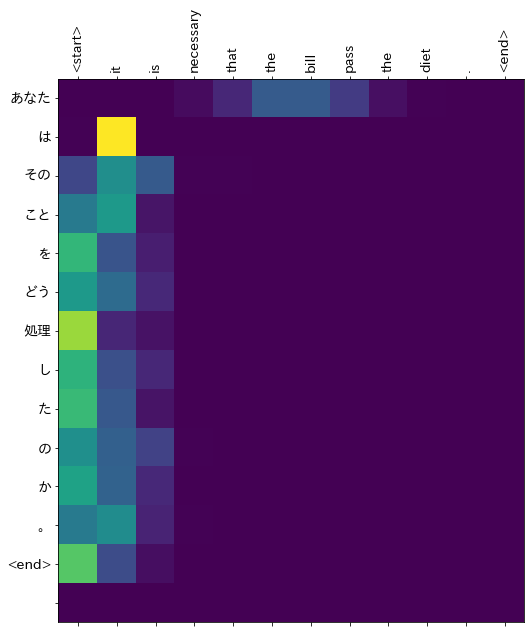

In [76]:
translate('It is necessary that the bill pass the diet.')

In [79]:
def predict(inputs):
    inputs = tf.convert_to_tensor([inputs])
    predicted_seq = []
    
    enc_out, enc_hidden = encoder(inputs)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()

        predicted_seq.append(predicted_id)

        if targ_lang.index_word[predicted_id] == '<end>':
            return predicted_seq

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return predicted_seq
    

In [80]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

input_sentences = []
target_sentences = []
predicted_sentences = []

for i, input_en in enumerate(input_tensor_val):
    predicted_ja = predict(input_en)
    tokens_input = [inp_lang.index_word[id] for id in input_en if id > 2]
    tokens_target = [targ_lang.index_word[id] for id in target_tensor_val[i] if id > 2]
    tokens_predicted = [targ_lang.index_word[id] for id in predicted_ja if id > 2]
    input_sentences.append(' '.join(tokens_input))
    target_sentences.append(''.join(tokens_target))
    predicted_sentences.append(''.join(tokens_predicted))

result_df = pd.DataFrame({'input_sentence': input_sentences,
                          'target_sentence': target_sentences,
                          'predicted_sentence': predicted_sentences})  


In [81]:
bleu_scores = []
for row in result_df.itertuples():
    bleu_scores.append(
        sentence_bleu(row.target_sentence, row.predicted_sentence,
                      smoothing_function=SmoothingFunction().method3)
    )
result_df['bleu_score'] = bleu_scores

In [82]:
result_df

,input_sentence,target_sentence,predicted_sentence,bleu_score
0,his wife speaks spanish as well as english .,あの人の奥さんは、英語だけでなくスペイン語も話します。,あの人の人たちはおもしろくない。,0.042359
1,you are nodding over your work .,あなたはお仕事しながらこっくりしてますよ。,あなたはそのことをどう処理したのか。,0.034934
2,take the book which is lying on that table .,あのテーブルの上にある本を取って下さい。,あなたのお宅の皆様によろしく。,0.037165
3,let's drink the cup of tea here .,ここで紅茶を飲みましょう。,ここでは喫煙にご遠慮下さい。,0.037374
4,there are a number of places to see in this ci...,この市には見物する所がかなりある。,このようなことが二度と起こらないよう努力します。,0.024623
...,...,...,...,...
2995,i may have caught cold on that cold night .,あの寒い夜に風邪を引いたのかもしれない。,この夏は雷が多かった。,0.053002
2996,it seems like yesterday that we skated together .,いっしょにスケートをしたのが、まるで昨日のことみたいです。,あの人たちにはやさしすぎました。,0.039779
2997,you have a standing invitation to join us .,いつおいでくださっても歓迎いたします。,あなたはそのことを後悔するだろう。,0.032342
2998,"koko herself cannot use spoken language , but ...",ココ自身は話し言葉を使えないが、彼女は人々の会話を聞くのが大好きである。,あの人たちの小屋は谷間にある。,0.041130


In [83]:
dir(result_df)

['T',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__re

In [88]:
result_df.bleu_score.mean()

0.035047338544287376